In [190]:
import voc_data
from anchor import generate_default_boxes
import yaml
import image_utils as util
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import random

In [281]:
with open('config.yml') as f:
    cfg = yaml.load(f, Loader=yaml.Loader)

try:
    config = cfg['SSD300']
except AttributeError:
    raise ValueError('Unknown architecture: {}'.format('e'))

default_boxes = generate_default_boxes(config)

In [282]:
gen = voc_data.VOCDataset('/home/workspace/iot_ai_model/dataset/server_room/test_digit.txt', default_boxes, 300)

In [286]:
def random_translate(img, boxes):
    w, h = img.size
    boxes = boxes * [w, h, w, h]
    boxes = boxes.astype(int)
    
    # 왼쪽의 여유공간을 오른쪽으로 할당. 나머지 공간도 반대쪽으로 할당
    right = min(boxes[:, 0])
    left = w - max(boxes[:, 2])
    bottom = min(boxes[:, 1])
    top = h - max(boxes[:, 3])
    
    pixel_x = left + right
    pixel_y = top + bottom
    
    result = Image.new(mode = img.mode, size = (w + pixel_x, h + pixel_y), color = (144,144,144))
    result.paste(img, (left, top))
    img = result
    
    new_x = int(pixel_x * random.uniform(0.1, 0.9))
    new_y = int(pixel_y * random.uniform(0.1, 0.9))
    img = result.crop((new_x, new_y, w + new_x, h + new_y))
    
    boxes = (boxes + [left - new_x, top - new_y, left - new_x, top - new_y]) / [w, h, w, h]
    return img, boxes

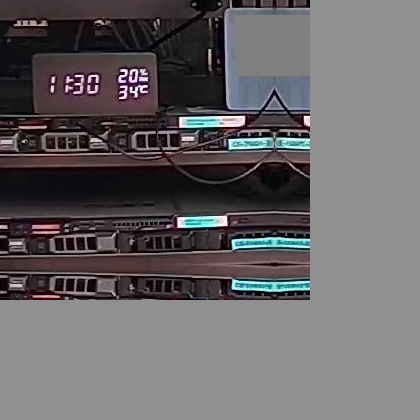

In [287]:
img = gen._get_image(0)
anno = gen._get_annotation(0, (350,350))

img, boxes = util.random_resize(img, anno[0])
img, boxes = random_translate(img, boxes)
w, h = img.size
np_img = np.array(img)
opencv_image=cv2.cvtColor(np_img, cv2.COLOR_RGB2BGR)
img

[ 86  71 101  96] (420, 420, 3)
[126  66 137  83] (420, 420, 3)
[49 71 56 96] (420, 420, 3)
[61 71 71 96] (420, 420, 3)
[115  66 126  83] (420, 420, 3)
[71 71 85 96] (420, 420, 3)
[115  82 126 102] (420, 420, 3)
[126  83 138  99] (420, 420, 3)


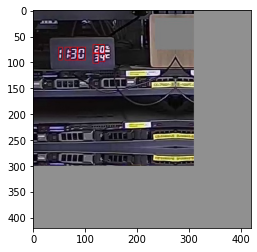

In [288]:
for box in boxes:
    box = np.array(box * [w , h, w, h], dtype=np.int16)
    print(box, opencv_image.shape)
    cv2.rectangle(opencv_image, (box[0], box[1]),(box[2], box[3]), (255,0,0), 1)

plt.imshow(opencv_image)

In [4]:
for filename, img, gt_confs, gt_locs in gen.generate():
    break
    
    

In [11]:
path = '/home/workspace/iot_ai_model/dataset/server_room/test/1500_image_4_0_0.jpg'

AttributeError: module 'cv2' has no attribute 'readimg'

In [1]:
import numpy as np
import torch
import torchvision.models as models
from tensorflow import keras
from tensorflow.keras import layers

from resnet import resnet18

/usr/local/lib/python3.6/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
inputs = keras.Input(shape=(None, None, 3))
outputs = resnet18(inputs)
model = keras.Model(inputs, outputs)

In [18]:
# Compare outputs
input_batch = np.random.rand(4, 300, 300, 3).astype(model.dtype)
output = model(input_batch, training=True).numpy()
with torch.no_grad():
    torch_output = torch_model(torch.tensor(input_batch.transpose((0, 3, 1, 2)))).numpy()
print(np.abs(output - torch_output).max())

2.2459514


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, None, None, 6 256         conv1[0][0]                      
______________________________________________________________________________________________

In [45]:
[1,2,3,4,5][-1]

5

In [1]:
from network import SSD
from layers import create_vgg16_layers
import tensorflow as tf

In [2]:
ssd = SSD(num_classes=11, model='resnet18')
ssd(tf.random.normal((1, 300, 300, 3)))

(1, 38, 38, 128)
(1, 19, 19, 256)


(<tf.Tensor: shape=(1, 8732, 11), dtype=float32, numpy=
 array([[[-0.00052965, -0.04184864, -0.12359098, ...,  0.05020572,
          -0.00839984, -0.02258922],
         [ 0.06944185,  0.08186201,  0.04674813, ...,  0.03986267,
           0.00074855, -0.17430115],
         [-0.03044923,  0.17401022, -0.10653434, ..., -0.09024815,
           0.02841486, -0.05401523],
         ...,
         [-0.02463972, -0.00714908,  0.01672807, ..., -0.09126395,
          -0.08288169,  0.21066162],
         [-0.23750922,  0.13799483, -0.1609777 , ..., -0.05993638,
           0.03829479,  0.0959122 ],
         [ 0.10127339, -0.23666036,  0.07441285, ...,  0.06531173,
          -0.0699366 ,  0.23602442]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 8732, 4), dtype=float32, numpy=
 array([[[-0.02903651, -0.0253081 ,  0.14435925,  0.10288054],
         [ 0.01206862, -0.01228355,  0.06364486,  0.08620244],
         [ 0.02092158,  0.2176159 , -0.03510997,  0.04303738],
         ...,
         [ 0.0397967 , -0.109

In [3]:
ssd = SSD(num_classes=11, model='resne3t18')
ssd(tf.random.normal((1, 300, 300, 3)))

(1, 38, 38, 512)
(1, 19, 19, 1024)


(<tf.Tensor: shape=(1, 8732, 11), dtype=float32, numpy=
 array([[[ 1.0527390e-02, -8.3111916e-03,  6.8487085e-02, ...,
          -3.2465208e-02, -1.0575029e-02, -4.9946241e-02],
         [ 6.9181725e-02,  5.0424684e-02,  4.6365339e-02, ...,
           5.4168649e-02, -2.3314249e-02, -2.0586202e-02],
         [-1.9948702e-02, -2.2666417e-02,  1.2069251e-02, ...,
          -6.4227365e-02,  1.8705396e-02,  4.1814476e-02],
         ...,
         [-1.2627878e-04, -1.1853725e-05,  5.8366419e-05, ...,
          -1.7567843e-05, -1.0405449e-05, -6.2823106e-05],
         [ 8.8772023e-05, -3.8995928e-05,  7.7191507e-06, ...,
           1.0070618e-05, -3.2633983e-05,  7.4087620e-05],
         [ 2.3690860e-05,  7.8688492e-05, -3.5621499e-05, ...,
           8.0147962e-05,  1.2996816e-04, -7.7940960e-05]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 8732, 4), dtype=float32, numpy=
 array([[[-3.1676844e-02, -2.5003485e-02,  3.7296899e-02, -4.0799364e-02],
         [ 5.7802820e-03,  5.1716927e-02, -6.4130

In [40]:
layer = create_vgg16_layers()

In [47]:
layer[1].summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, None, None, 512)] 0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, None, None, 512)   0         
_________________________________________________________________
conv2d_184 (Conv2D)          (None, None, None, 1024)  4719616   
_________________________________________________________________
conv2d_185 (Conv2D)          (None, None, None, 1024)  1049600   
Total params: 5,769,216
Trainable params: 5,769,216
Non-trainable params: 0
_________________________________________________________________


In [46]:
layer[0].summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d_171 (Conv2D)          (None, None, None, 64)    1792      
_________________________________________________________________
conv2d_172 (Conv2D)          (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, None, None, 64)    0         
_________________________________________________________________
conv2d_173 (Conv2D)          (None, None, None, 128)   73856     
_________________________________________________________________
conv2d_174 (Conv2D)          (None, None, None, 128)   147584    
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, None, None, 128)   0  

(<tf.Tensor: shape=(1, 24660, 11), dtype=float32, numpy=
 array([[[-8.71404447e-03,  7.68104419e-02, -1.83890644e-03, ...,
          -2.64364830e-03, -1.42960185e-02,  2.78067496e-02],
         [-1.68991592e-02,  1.83278490e-02,  4.21257019e-02, ...,
          -1.65405907e-02, -1.59627292e-02,  1.82029959e-02],
         [ 6.72905194e-03,  1.41115906e-02,  4.75401208e-02, ...,
          -4.18188274e-02,  2.07038596e-03,  2.30743755e-02],
         ...,
         [-1.99050319e-05, -1.04682775e-04, -4.02268124e-05, ...,
          -1.78633127e-06,  1.80064417e-05,  7.62507407e-05],
         [ 2.25444655e-05, -3.05791036e-05, -3.35456934e-06, ...,
           1.73970566e-05,  5.10201062e-06, -8.39642016e-05],
         [ 1.96759538e-05,  4.31007811e-06,  1.14835075e-06, ...,
          -9.32202238e-06,  3.08589879e-05, -2.31550403e-05]]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 24660, 4), dtype=float32, numpy=
 array([[[-4.30452824e-03, -4.71384786e-02, -3.83469202e-02,
          -1.95038

In [37]:
ssd.summary()

Model: "ssd_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_10 (Functional)        (None, None, None, 512)   14714688  
_________________________________________________________________
model_11 (Functional)        (None, None, None, 1024)  5769216   
_________________________________________________________________
batch_normalization_3 (Batch multiple                  2048      
_________________________________________________________________
sequential_15 (Sequential)   (1, 16, 16, 512)          1442560   
_________________________________________________________________
sequential_16 (Sequential)   (1, 8, 8, 256)            360832    
_________________________________________________________________
sequential_17 (Sequential)   (1, 6, 6, 256)            328064    
_________________________________________________________________
sequential_18 (Sequential)   (1, 4, 4, 256)            328064

In [1]:
from resnet import resnet18_layers

In [2]:
layer3, layer4 = resnet18_layers()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: layer2.1.relu2/Relu:0


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "conv1_pad". The following previous layers were accessed without issue: []

In [7]:
# Adapted from https://github.com/pytorch/vision/blob/v0.4.0/torchvision/models/resnet.py
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=1000):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
    x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
    x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x

def resnet18_layers():
    x = keras.Input(shape=(None, None, 3))
    blocks_per_layer = [2, 2, 2, 2]
    
    out = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    out = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(out)
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(out)
    out = layers.ReLU(name='relu1')(out)
    out = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(out)
    out = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(out)

    out = make_layer(out, 64, blocks_per_layer[0], name='layer1')
    out = make_layer(out, 128, blocks_per_layer[1], stride=2, name='layer2')
    out = make_layer(out, 256, blocks_per_layer[2], stride=2, name='layer3')
    layer3 = keras.Model(x, out)
    
    x = keras.Input(shape=(None, None, 512))
    out = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')
    layer4 = keras.Model(x, out)
    
    return layer3, layer4
    
def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

def resnet34(x, **kwargs):
    return resnet(x, [3, 4, 6, 3], **kwargs)

In [8]:
layer3, layer4 = resnet18_layers()

In [9]:
layer3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, None, None, 6 256         conv1[0][0]                      
____________________________________________________________________________________________

In [1]:
import tensorflow as tf

In [2]:
tf.config.gpu.set_per_process_memory_growth(True)

AttributeError: module 'tensorflow._api.v2.config' has no attribute 'gpu'

In [10]:
import itertools

In [29]:
for i, j, z in itertools.product(range(5), repeat=3):
    print(i,j, z)

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
0 1 0
0 1 1
0 1 2
0 1 3
0 1 4
0 2 0
0 2 1
0 2 2
0 2 3
0 2 4
0 3 0
0 3 1
0 3 2
0 3 3
0 3 4
0 4 0
0 4 1
0 4 2
0 4 3
0 4 4
1 0 0
1 0 1
1 0 2
1 0 3
1 0 4
1 1 0
1 1 1
1 1 2
1 1 3
1 1 4
1 2 0
1 2 1
1 2 2
1 2 3
1 2 4
1 3 0
1 3 1
1 3 2
1 3 3
1 3 4
1 4 0
1 4 1
1 4 2
1 4 3
1 4 4
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
2 1 0
2 1 1
2 1 2
2 1 3
2 1 4
2 2 0
2 2 1
2 2 2
2 2 3
2 2 4
2 3 0
2 3 1
2 3 2
2 3 3
2 3 4
2 4 0
2 4 1
2 4 2
2 4 3
2 4 4
3 0 0
3 0 1
3 0 2
3 0 3
3 0 4
3 1 0
3 1 1
3 1 2
3 1 3
3 1 4
3 2 0
3 2 1
3 2 2
3 2 3
3 2 4
3 3 0
3 3 1
3 3 2
3 3 3
3 3 4
3 4 0
3 4 1
3 4 2
3 4 3
3 4 4
4 0 0
4 0 1
4 0 2
4 0 3
4 0 4
4 1 0
4 1 1
4 1 2
4 1 3
4 1 4
4 2 0
4 2 1
4 2 2
4 2 3
4 2 4
4 3 0
4 3 1
4 3 2
4 3 3
4 3 4
4 4 0
4 4 1
4 4 2
4 4 3
4 4 4


In [30]:
import math

In [48]:
0.2 * math.sqrt(2), 0.2 / math.sqrt(2) 

(0.28284271247461906, 0.1414213562373095)

In [49]:
0.2 * math.sqrt(3) , 0.2 / math.sqrt(3) 

(0.34641016151377546, 0.11547005383792516)